In [33]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [34]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print(f'Train shape : {train.shape}')
print(f'Test shape : {test.shape}')

Train shape : (1460, 81)
Test shape : (1459, 80)


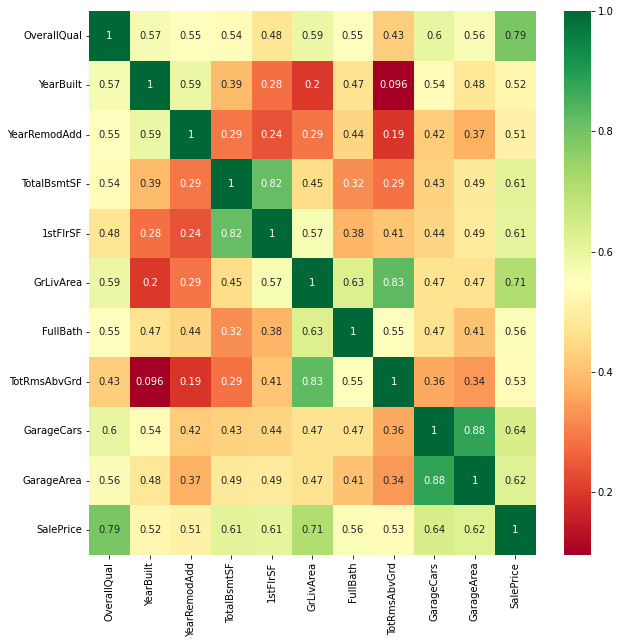

In [35]:
corr = train.corr()
highly_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
map = sns.heatmap(train[highly_corr_features].corr(),annot=True,cmap="RdYlGn")

In [36]:
corr["SalePrice"].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

In [37]:
# Bring train and test together for pre processing and featur engineering

data = pd.concat([train,test], axis=0)
y_train = train['SalePrice']
data = data.drop(['Id', 'SalePrice'], axis=1)
print(data.shape)

(2919, 79)


In [38]:
print('UNIQUE VALUES\n')
for col in data.columns:
    print(f'{col}: {len(data[col].unique())}\n')

UNIQUE VALUES

MSSubClass: 16

MSZoning: 6

LotFrontage: 129

LotArea: 1951

Street: 2

Alley: 3

LotShape: 4

LandContour: 4

Utilities: 3

LotConfig: 5

LandSlope: 3

Neighborhood: 25

Condition1: 9

Condition2: 8

BldgType: 5

HouseStyle: 8

OverallQual: 10

OverallCond: 9

YearBuilt: 118

YearRemodAdd: 61

RoofStyle: 6

RoofMatl: 8

Exterior1st: 16

Exterior2nd: 17

MasVnrType: 5

MasVnrArea: 445

ExterQual: 4

ExterCond: 5

Foundation: 6

BsmtQual: 5

BsmtCond: 5

BsmtExposure: 5

BsmtFinType1: 7

BsmtFinSF1: 992

BsmtFinType2: 7

BsmtFinSF2: 273

BsmtUnfSF: 1136

TotalBsmtSF: 1059

Heating: 6

HeatingQC: 5

CentralAir: 2

Electrical: 6

1stFlrSF: 1083

2ndFlrSF: 635

LowQualFinSF: 36

GrLivArea: 1292

BsmtFullBath: 5

BsmtHalfBath: 4

FullBath: 5

HalfBath: 3

BedroomAbvGr: 8

KitchenAbvGr: 4

KitchenQual: 5

TotRmsAbvGrd: 14

Functional: 8

Fireplaces: 5

FireplaceQu: 6

GarageType: 7

GarageYrBlt: 104

GarageFinish: 4

GarageCars: 7

GarageArea: 604

GarageQual: 6

GarageCond: 

In [39]:
data[data.select_dtypes(exclude='object').columns].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [40]:
#Columns containing most null values
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10))

              Total    Percent
PoolQC         2909  99.657417
MiscFeature    2814  96.402878
Alley          2721  93.216855
Fence          2348  80.438506
FireplaceQu    1420  48.646797
LotFrontage     486  16.649538
GarageYrBlt     159   5.447071
GarageFinish    159   5.447071
GarageQual      159   5.447071
GarageCond      159   5.447071


In [41]:
#Dropping columns with > 5 null values
data.drop((missing_data[missing_data['Total'] > 5]).index, axis=1, inplace=True)
#Sorting columns w.r.t null values
total = data.isnull().sum().sort_values(ascending=False)
total.head(20)


MSZoning        4
Functional      2
BsmtFullBath    2
BsmtHalfBath    2
Utilities       2
BsmtFinSF2      1
Exterior2nd     1
GarageCars      1
GarageArea      1
BsmtFinSF1      1
BsmtUnfSF       1
Exterior1st     1
TotalBsmtSF     1
Electrical      1
SaleType        1
KitchenQual     1
HalfBath        0
FullBath        0
BedroomAbvGr    0
KitchenAbvGr    0
dtype: int64

In [42]:
#Filling the numeric data
numeric_missed = ['BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'BsmtFullBath',
'BsmtHalfBath',
'GarageArea',
'GarageCars']
for feature in numeric_missed:
    #data[feature] = data[feature].fillna(0)
    data[feature] = data[feature].fillna(data[feature].mean())
#Filling the categorical data
categorical_missed = ['Exterior1st',
'Exterior2nd',
'SaleType',
'MSZoning',
'Electrical',
'KitchenQual',
'Functional']
for feature in categorical_missed:
    data[feature] = data[feature].fillna(data[feature].mode()[0])
#Deleting 'Utilities' column
data.drop(['Utilities'], axis=1, inplace=True)


In [43]:
#Top skewed columns
numeric_features = data.dtypes[data.dtypes != 'object'].index
skewed_features = data[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
print(high_skew)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146034
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931343
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425233
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.162484
BsmtUnfSF         0.919508
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.623955
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64


In [44]:
#Transforming skewed columns
for feature in high_skew.index:
    data[feature] = np.log1p(data[feature])

In [45]:
#Converting categorical data to numerical
data = pd.get_dummies(data)
data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,9.042040,7,1.791759,7.602900,2003,6.561031,0.0,5.017280,6.753438,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,9.169623,6,2.197225,7.589336,1976,6.886532,0.0,5.652489,7.141245,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,9.328212,7,1.791759,7.601902,2002,6.188264,0.0,6.075346,6.825460,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,9.164401,7,1.791759,7.557995,1970,5.379897,0.0,6.293419,6.629363,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,9.565284,8,1.791759,7.601402,2000,6.486161,0.0,6.196444,7.044033,...,0,0,0,1,0,0,0,0,1,0


In [46]:
#Dividing data back into train & test
train =data[:len(y_train)]
test = data[len(y_train):]
#Printing thier shapes
print(train.shape, test.shape)

(1460, 218) (1459, 218)


<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

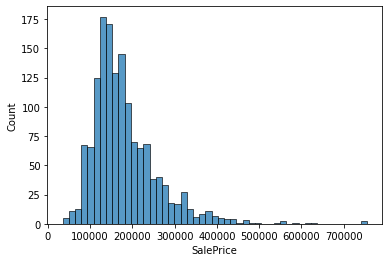

In [47]:
# visualization of housing prices
fig = plt.figure()
fig.add_subplot()
sns.histplot(y_train)

In [48]:
# [CHECKPOINT 5][5 points]
def  feature_normalization(X):
    """
    Normalizes the features in X. returns a normalized version of X where
    the mean value of each feature is 0 and the standard deviation
    is 1. This is often a good preprocessing step to do when working with
    learning algorithms.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n).
    
    Returns
    -------
    X_norm : array_like
        The normalized dataset of shape (m x n).
    
    Instructions
    ------------
    First, for each feature dimension, compute the mean of the feature
    and subtract it from the dataset, storing the mean value in mu. 
    Next, compute the  standard deviation of each feature and divide
    each feature by it's standard deviation, storing the standard deviation 
    in sigma. 
    
    Note that X is a matrix where each column is a feature and each row is
    an example. You needto perform the normalization separately for each feature. 
    
    Hint
    ----
    You might find the 'np.mean' and 'np.std' functions useful.
    """
    mu = []
    sigma = []
    X_norm = np.copy(X)
    
    col_to_remove = []
    for i in range(X_norm.shape[1]):
        mu.append(np.mean(X_norm[:,i]))
        sigma.append(np.std(X_norm[:,i]))
    X_norm = np.delete(X_norm, col_to_remove, axis=1)

    # =========================== YOUR CODE HERE =====================
    for i in range(X_norm.shape[1]):
        if np.std(X_norm[:,i]) != 0:
            X_norm[:,i] = (X_norm[:,i] - np.mean(X_norm[:,i])) / np.std(X_norm[:,i])
        else:
            X_norm[:,i] = (X_norm[:,i] - np.mean(X_norm[:,i])) / 0.01
    
    
    # ================================================================
    return X_norm, mu, sigma

In [49]:
normal_data, mu, sigma = feature_normalization(train)
# Add intercept Column
normal_data = np.insert(normal_data, 0, np.ones(normal_data.shape[0]), axis=1)
#normal_data[:,0] = np.ones(data.shape[0])
pd.DataFrame(normal_data)

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,216,217,218
0,1.0,0.424462,-0.133270,0.651479,-0.460408,1.045180,0.878668,0.779431,-0.355342,-0.340511,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1,1.0,-1.125202,0.113413,-0.071836,1.948163,0.163445,-0.429577,0.888257,-0.355342,0.002218,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
2,1.0,0.424462,0.420049,0.651479,-0.460408,0.980275,0.830215,0.654803,-0.355342,0.230372,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
3,1.0,0.645073,0.103317,0.651479,-0.460408,-1.873790,-0.720298,0.384539,-0.355342,0.348034,...,-0.058621,-0.301962,-0.045376,0.390293,3.668167,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995
4,1.0,0.424462,0.878431,1.374795,-0.460408,0.947798,0.733308,0.754400,-0.355342,0.295711,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.0,0.424462,-0.259231,-0.071836,-0.460408,0.915305,0.733308,-1.414140,-0.355342,0.654093,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1456,1.0,-1.125202,0.725429,-0.071836,0.455288,0.229170,0.151865,0.816966,2.409693,0.394815,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1457,1.0,0.645073,-0.002359,0.651479,2.574033,-0.997641,1.024029,0.464947,-0.355342,0.609301,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1458,1.0,-1.125202,0.136833,-0.795151,0.455288,-0.697090,0.539493,-0.106220,3.405917,-3.047600,...,-0.058621,-0.301962,-0.045376,0.390293,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


In [50]:
# Only utilize top 10 features
top_normal_data = normal_data.copy()
corr_threshold = 0.5
cols = []
for i in range(normal_data.shape[1]):
    corr = np.corrcoef(list(normal_data[:,i]), list(y_train))
    if abs(corr[0,1]) < corr_threshold:
        cols.append(i)
top_normal_data = np.delete(top_normal_data, cols, axis=1)

print(top_normal_data.shape)
normal_data = top_normal_data.copy()

(1460, 13)


c:\Users\mason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\mason\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [51]:
def compute_cost_multiple(X, y, theta):
    """
    Compute cost for linear regression with multiple variables.
    Computes the cost of using theta as the parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    Returns
    -------
    J : float
        The value of the cost function. 
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to the cost.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    #number of features
    n = X.shape[1]
    
    # You need to return the following variable correctly
    J = 0
        
    # ======================= YOUR CODE HERE ==========================
    outerSum = 0
    for i in range(m):
        innerSum = 0
        for j in range(n):
            innerSum += theta[j] * X[:,j][i]
        innerSum -= y[i]
        innerSum **= 2
        outerSum += innerSum
    
    J = (1 / (2 * m)) * outerSum
            
    return J



In [52]:
# [CHECKPOINT 7][8 points]
def gradient_descent_multiple(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn theta.
    Updates theta by taking num_iters gradient steps with learning rate alpha.
        
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    alpha : float
        The learning rate for gradient descent. 
    
    num_iters : int
        The number of iterations to run gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    
    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = y.shape[0]
    
    # Number of training sets and theta values
    n = X.shape[1]
    
    # make a copy of theta, which will be updated by gradient descent
    theta = theta.copy()
    
    J_history = []
    
    for it in range(num_iters):
        #partialDerivate = 0
        # ======================= YOUR CODE HERE ==========================
        for j in range(n): #for each theta to be changed
            partialDerivativeSum = 0
            for i in range(m): # PD sum
                hypothesisSum = 0
                for k in range(n): # for hypothesis calcs
                    #theta 0 * X[:,0][i] + theta1 * X[:,1][i] ...>
                    hypothesisSum += theta[k] * X[:,k][i]
                partialDerivativeSum += (hypothesisSum - y[i])*X[:,j][i]
            partialDerivative = (1 / m) * partialDerivativeSum
            theta[j] -= (alpha * partialDerivative)
        # =================================================================
        
        # save the cost J in every iteration
        J_history.append(compute_cost_multiple(X, y, theta))
    
    return theta, J_history


In [53]:
# Split Datasets for testing and training
x_train, x_test, y_train, y_test = train_test_split(normal_data, y_train, test_size=0.2)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [54]:
# Train func
def train_func(alpha, num_iters, x, y):
    # init theta and run gradient descent
    theta = np.zeros(normal_data.shape[1])
    theta, J_history = gradient_descent_multiple(x, y, theta, alpha, num_iters)
    return theta, J_history

    # Plot the convergence graph
    # Display the gradient descent's result
    #print('theta computed from gradient descent: {:s}'.format(str(theta)))

In [55]:
# Predict func
def predict(x, y):

    prediction = []
    for i in range(x.shape[0]):
        predict = np.matmul(np.transpose(theta), x[i,:])
        prediction.append(predict)
    RMSE = metrics.mean_squared_error(y, prediction,  squared=False)
    VarScore = metrics.explained_variance_score(y,prediction)
    return RMSE, VarScore

Alpha:  0.3
RMSE:  36138.05652663981
Var Score:  0.7858557116092593
Alpha:  0.1
RMSE:  36140.89134592542
Var Score:  0.7858221136671053
Alpha:  0.03
RMSE:  36265.90563671556
Var Score:  0.7843662871264883
Alpha:  0.01
RMSE:  44038.48830528708
Var Score:  0.777663391503522
Alpha:  0.003
RMSE:  106071.44863741621
Var Score:  0.7610028461386296
Alpha:  0.001
RMSE:  154591.36983801163
Var Score:  0.6727328732174493


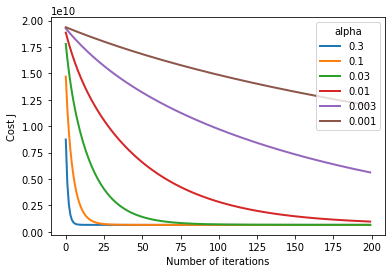

In [56]:
# Do training tests with different alphas
alphas = [0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
for alpha in alphas:
    # Train
    theta, J_history = train_func(alpha=alpha, num_iters=200, x=x_train, y=y_train)
    # predict
    RMSE, VarScore = predict(x_train,  y_train)
    print("Alpha: ", alpha)
    print("RMSE: ", RMSE)
    print("Var Score: ",  VarScore)

    # Plot the convergence graph
    plt.plot(np.arange(len(J_history)), J_history, lw=2)
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost J')
leg = plt.legend(alphas)
leg.set_title("alpha")

Alpha:  0.3
RMSE:  40590.185459106986
Var Score:  0.7692401730437753
Alpha:  0.1
RMSE:  40591.92260083179
Var Score:  0.7692204209305807
Alpha:  0.03
RMSE:  40640.28094464647
Var Score:  0.7687173571328967
Alpha:  0.01
RMSE:  48706.385418105165
Var Score:  0.7537349589177201
Alpha:  0.003
RMSE:  108334.2590071439
Var Score:  0.7113094792688379
Alpha:  0.001
RMSE:  155748.17047707623
Var Score:  0.6432119436996451


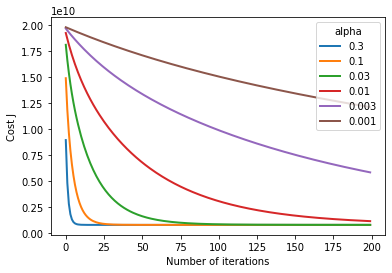

In [57]:
# Do training tests with different alphas
alphas = [0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
for alpha in alphas:
    # Train
    theta, J_history = train_func(alpha=alpha, num_iters=200, x=x_test, y=y_test)
    # predict
    RMSE, VarScore = predict(x_test,  y_test)
    print("Alpha: ", alpha)
    print("RMSE: ", RMSE)
    print("Var Score: ",  VarScore)

    # Plot the convergence graph
    plt.plot(np.arange(len(J_history)), J_history, lw=2)
    plt.xlabel('Number of iterations')
    plt.ylabel('Cost J')
leg = plt.legend(alphas)
leg.set_title("alpha")